## **Input experiment parameters**

In [ ]:
experiement_string = "DQN"
'''This is where the algorithm is decided for the experiement parameters
Allowing experiement_strings are :
"DQN"
“DQN+PER”
“DDQN”
“DDQN+PER”
“DDQN+D2QN”
“DDQN+D2QN+PER”
'''

'This is where the algorithm is decided for the experiement parameters\nAllowing experiement_strings are :\n"DQN"\n“DQN+PER”\n“DDQN”\n“DDQN+PER”\n“DDQN+D2QN”\n“DDQN+D2QN+PER”\n'

In [ ]:
save_name = "DDQN+D2QN+PER → DDQN+PER → DDQN+PER"
'''This is the DNN save name for automatic saving to Google Drive'''

'This is the DNN save name for automatic saving to Google Drive'

In [ ]:
transfer = False
''' Set transfer to False to enable a blank run and too True if you wish to transfer a model'''

' Set transfer to False to enable a blank run and too True if you wish to transfer a model'

In [ ]:
tranfser_file = "DDQN+D2QN+PER → DDQN+PER"
''' Set the file name for the DNN you wish to transfer to a new algorithm'''

' Set the file name for the DNN you wish to transfer to a new algorithm'

In [ ]:
transfer_type = "DQN→DQN"
''' Set the type of transfer learning experiement
Allowed options are:
"DQN→DQN"
"D2QN→DQN"
"DQN→D2QN"
"D2QN→D2QN"
'''

' Set the type of transfer learning experiement\nAllowed options are:\n"DQN→DQN"\n"D2QN→DQN"\n"DQN→D2QN"\n"D2QN→D2QN"\n'

In [ ]:
# 128 eval parm
do_hundrad_twenty_eight_evaluation_num = 25
save_max_tiles = False

In [ ]:
'''Connect to drive'''
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## **Train agent logic**

In [ ]:
!pip install cpprb 
!pip install tabulate 

In [ ]:
from cpprb import ReplayBuffer,PrioritizedReplayBuffer
import cpprb
from tabulate import tabulate

In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl

import sys
import pickle
import tensorflow as tf
from tensorflow import keras
# import gym

from time import ctime
import time
# import gym_2048
import sys
import pickle
import numpy as np
import math
from numba.experimental import jitclass
from numba import jit
from numba import njit, gdb_init
from numba import uint32, int32, int32, b1, float64, float32


In [ ]:
class pickle_class:
    def __init__(self,episode,steps,tiles,board_sum,score):
        self.episode = episode
        self.steps = steps
        self.tiles = tiles
        self.board_sum = board_sum
        self.score = score


def check_board_update(state,next_state,env):

    if np.array_equal(state,next_state):

        next_state_flat = next_state.flatten()


        smallest_index = np.where(next_state_flat==np.min(next_state_flat))
  
        random_index = np.random.choice(smallest_index[0])


        if np.random.uniform(0,1) > 0.1:

            next_state_flat[random_index] = 2

        else:
            next_state_flat[random_index] = 4

        next_state = next_state_flat.reshape(4,-1)
     
        env.set_board(next_state)
  
    return next_state,env

def normalise_training_samples(states,next_states,rewards):

  # normalise state
  normalised_states = np.array([],dtype=np.float32)

  for board in states:

    normalised_board = np.array([],dtype=np.float32)

    for tile in board:

      if np.array_equal(tile,0):

        normalised_board = np.append(normalised_board,0)

      else:
      
        normalised_board = np.append(normalised_board,np.log2(tile)/7)

    
    normalised_states = np.append(normalised_states,normalised_board)


  # print("states ",states)

  normalised_states = normalised_states.reshape(-1,16)

  # normalise next state
  normalised_next_states = np.array([],dtype=np.float32)

  for board in next_states:

    normalised_board = np.array([],dtype=np.float32)

    for tile in board:

      if np.array_equal(tile,0):

        normalised_board = np.append(normalised_board,0)

      else:
      
        normalised_board = np.append(normalised_board,np.log2(tile)/7)


    
    normalised_next_states = np.append(normalised_next_states,normalised_board)

  normalised_next_states = normalised_next_states.reshape(-1,16)


  # normliase reward 


  # normliased_rewards = (rewards-1)/8
  normalised_rewards = np.array([],dtype=np.float32)

  for tile in rewards:

    if tile == -1:

      normalised_rewards = np.append(normalised_rewards,-1)

    elif tile == 0:

      normalised_rewards = np.append(normalised_rewards,0)

    else:
      
      normalised_rewards = np.append(normalised_rewards,np.log2(tile)/7)

  normalised_rewards = normalised_rewards.astype('float32')


  return normalised_states,normalised_next_states,normalised_rewards

def sample_experiences_per(batch_size):
	sample = replay_memory.sample(batch_size,beta)
	print("beta ",beta) 
	
	states, actions, rewards, next_states, dones, weights, indexes = sample['obs'],sample['act'],sample['rew'],sample['next_obs'],sample['done'],sample['weights'],sample['indexes']
  
	actions = np.reshape(actions,(batch_size,))
	rewards = np.reshape(rewards,(batch_size,))
	dones = np.reshape(dones,(batch_size,))
	# weights = np.reshape(weights,(batch_size,-1))


	return np.reshape(states,(batch_size,16)), actions, rewards, np.reshape(next_states,(batch_size,16)), dones, weights,indexes

def sample_experiences(batch_size):
	sample = replay_memory.sample(batch_size)
	states, actions, rewards, next_states, dones = sample['obs'],sample['act'],sample['rew'],sample['next_obs'],sample['done']
    
	actions = np.reshape(actions,(batch_size,))
	rewards = np.reshape(rewards,(batch_size,))
	dones = np.reshape(dones,(batch_size,))


	return np.reshape(states,(batch_size,16)), actions, rewards, np.reshape(next_states,(batch_size,16)), dones

def epsilon_greedy_policy(state, epsilon=0):
	if np.random.rand() < epsilon:
		return np.random.randint(n_outputs)
	else:

		# normalise state
		normalised_board = np.array([],dtype=np.float32)

		for tile in state.flatten():

			if np.array_equal(tile,0):

				normalised_board = np.append(normalised_board,0)

			else:
      
				normalised_board = np.append(normalised_board,np.log2(tile)/7)
		
		Q_values = model.predict(normalised_board[np.newaxis])
  

  
	return np.argmax(Q_values[0])

def play_one_step(env, state, epsilon,append_times,step_times,policy_times):
	start_step_time = time.time()


	start_policy_time = time.time()
	action = epsilon_greedy_policy(state, epsilon)
	end_policy_time = time.time()

	policy_times = np.append(policy_times,end_policy_time-start_policy_time)

	env.make_move(action)

	env.confirm_move()

	next_state = env.get_board()

	reward = env.get_move_score()

	done, _ = env.verify_game_state()
 
	merges = env.get_merges()

	start_replay_buffer_time = time.time()
	replay_memory.add(obs=state,act=action,rew=reward,next_obs=next_state,done=done)
	end_replay_buffer_time = time.time()

	append_times = np.append(append_times,end_replay_buffer_time-start_replay_buffer_time)
 
	end_step_time = time.time()

	step_times = np.append(step_times,end_step_time-start_step_time)

	return next_state, reward, done ,append_times,step_times,policy_times

@tf.function(experimental_compile=True)
def train_model_vanilla(states, actions, rewards, next_states, dones):
	next_Q_values = model(next_states)
	max_next_Q_values = tf.math.reduce_max(next_Q_values, axis=1)
	target_Q_values = (rewards + (1 - dones) * discount_rate * max_next_Q_values)
	target_Q_values = tf.reshape(target_Q_values,[-1,1])
	mask = tf.one_hot(actions, n_outputs)
	with tf.GradientTape() as tape:
		all_Q_values = model(states)
		Q_values = tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True)
		loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values))
	grads = tape.gradient(loss, model.trainable_variables)
	optimizer.apply_gradients(zip(grads, model.trainable_variables))

@tf.function(experimental_compile=True)
def train_model_double(states, actions, rewards, next_states, dones):
  next_Q_values = model(next_states)    
  best_next_actions = tf.math.argmax(next_Q_values,axis = 1)
  next_mask = tf.one_hot(best_next_actions,n_outputs)
  next_best_Q_values =  tf.math.reduce_sum(target(next_states) * next_mask,axis = 1)
  target_Q_values = (rewards + (1 - dones) * discount_rate * next_best_Q_values)
  target_Q_values = tf.reshape(target_Q_values,[-1,1])
  mask = tf.one_hot(actions, n_outputs)
  with tf.GradientTape() as tape:
    all_Q_values = model(states)
    Q_values = tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True)
    loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values))
  grads = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(grads, model.trainable_variables))

@tf.function(experimental_compile=True)
def train_model_per(states, actions, rewards, next_states, dones,weights,indexes):
	next_Q_values = model(next_states)
	max_next_Q_values = tf.math.reduce_max(next_Q_values, axis=1)
	target_Q_values = (rewards + (1 - dones) * discount_rate * max_next_Q_values)
	target_Q_values = tf.reshape(target_Q_values,[-1,1])
	mask = tf.one_hot(actions, n_outputs)
	with tf.GradientTape() as tape:
		all_Q_values = model(states)
		Q_values = tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True)
		loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values)*weights)
	grads = tape.gradient(loss, model.trainable_variables)
	optimizer.apply_gradients(zip(grads, model.trainable_variables))
	return tf.math.abs(target_Q_values - Q_values)

@tf.function(experimental_compile=True)
def train_model_double_per(states, actions, rewards, next_states, dones,weights,indexes):
	next_Q_values = model(next_states)    
	best_next_actions = tf.math.argmax(next_Q_values,axis = 1)
	next_mask = tf.one_hot(best_next_actions,n_outputs)
	next_best_Q_values =  tf.math.reduce_sum(target(next_states) * next_mask,axis = 1)
	target_Q_values = (rewards + (1 - dones) * discount_rate * next_best_Q_values)
	target_Q_values = tf.reshape(target_Q_values,[-1,1])
	mask = tf.one_hot(actions, n_outputs)
	with tf.GradientTape() as tape:
		all_Q_values = model(states)
		Q_values = tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True)
		loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values)*weights)
	grads = tape.gradient(loss, model.trainable_variables)
	optimizer.apply_gradients(zip(grads, model.trainable_variables))
	return tf.math.abs(target_Q_values - Q_values)

def training_step_per(batch_size):
	training_start = time.time()

	start_replay_buffer_time = time.time()
	experiences = sample_experiences_per(batch_size)
	end_replay_buffer_time = time.time()
	states, actions, rewards, next_states, dones, weights,indexes = experiences


	states,next_states,rewards = normalise_training_samples(states,next_states,rewards)
	
	

	weights = train_model(states, actions, rewards, next_states, dones,weights,weights)
 
 
  # adding the temporal difference error to the buffer
	replay_memory.update_priorities(indexes,weights)

	sample_time = end_replay_buffer_time-start_replay_buffer_time

	training_end = time.time()

	training_time = training_end-training_start

	states,next_states,rewards = normalise_training_samples(states,next_states,rewards)

	return sample_time,training_time

def training_step_vanilla(batch_size):
	training_start = time.time()

	start_replay_buffer_time = time.time()
	experiences = sample_experiences(batch_size)
	end_replay_buffer_time = time.time()
	states, actions, rewards, next_states, dones = experiences

	

	states,next_states,rewards = normalise_training_samples(states,next_states,rewards)

	
	
	train_model(states, actions, rewards, next_states, dones)

	sample_time = end_replay_buffer_time-start_replay_buffer_time

	training_end = time.time()

	training_time = training_end-training_start

	states,next_states,rewards = normalise_training_samples(states,next_states,rewards)

	return sample_time,training_time




In [ ]:
experiement_string = "DDQN+D2QN+PER"
'''This is where the algorithm is decided for the experiement parameters
Allowing experiement_strings are :
"DQN"
“DQN+PER”
“DDQN”
“DDQN+PER”
“DDQN+D2QN”
“DDQN+D2QN+PER”
'''

'This is where the algorithm is decided for the experiement parameters\nAllowing experiement_strings are :\n"DQN"\n“DQN+PER”\n“DDQN”\n“DDQN+PER”\n“DDQN+D2QN”\n“DDQN+D2QN+PER”\n'

## **Set algorithm**

In [ ]:
if experiement_string == "DQN":
  training_step = training_step_vanilla
  train_model = train_model_vanilla

  learning_rate = 0.01
  loss_fn = keras.losses.mean_squared_error

elif experiement_string == "DQN+PER":
  training_step = training_step_per
  train_model = train_model_per

  learning_rate = 0.01
  loss_fn = keras.losses.mean_squared_error

elif experiement_string == "DDQN":
  training_step = training_step_vanilla
  train_model = train_model_double

  learning_rate = 0.006
  loss_fn = keras.losses.Huber()

elif experiement_string == "DDQN+PER":
  training_step = training_step_per
  train_model = train_model_double_per

  learning_rate = 0.006
  loss_fn = keras.losses.Huber()
  
elif experiement_string == "DDQN+D2QN":
  training_step = training_step_vanilla
  train_model = train_model_double

  learning_rate = 0.0075
  loss_fn = keras.losses.Huber()
  
elif experiement_string == "DDQN+D2QN+PER":
  training_step = training_step_per
  train_model = train_model_double_per

  learning_rate = 0.0075
  loss_fn = keras.losses.Huber()
  

## **Set transfer**

In [ ]:
directory = "DSPFinal/Saves"

episodes = 600

input_shape = [16]
n_outputs = 4

if not transfer:
  if experiement_string == "DQN" or experiement_string == "DQN+PER" or experiement_string == "DDQN" or experiement_string ==  "DDQN+PER":
    model = keras.models.Sequential([
    keras.layers.Dense(32, activation="elu", input_shape=input_shape),
    keras.layers.Dense(32, activation="elu"),
    keras.layers.Dense(n_outputs)
    ])
   


  elif experiement_string == "DDQN+D2QN" or experiement_string == "DDQN+D2QN+PER":
    K = keras.backend
    input_states = keras.layers.Input(shape=input_shape)
    hidden1 = keras.layers.Dense(32, activation="elu")(input_states)
    hidden2 = keras.layers.Dense(32, activation="elu")(hidden1)
    state_values = keras.layers.Dense(1)(hidden2)
    raw_advantages = keras.layers.Dense(n_outputs)(hidden2)
    advantages = raw_advantages - K.max(raw_advantages, axis=1, keepdims=True)
    Q_values = state_values + advantages
    model = keras.models.Model(inputs=[input_states], outputs=[Q_values])
  



else: 
  

  path = F"/content/gdrive/My Drive/{directory}/{tranfser_file}model" 
  old_model = keras.models.load_model(path)
  if transfer_type == "DQN→DQN" :
    old_model.summary()
    layers = old_model.layers[0:2]
    model = keras.models.Sequential()
    for i in layers:
      model.add(i)
    model.add(keras.layers.Dense(4,name = "dense_2"))
    model.summary()


  elif transfer_type == "D2QN→DQN" :
    old_model.summary()
    layers = old_model.layers[0:3]
    model = keras.models.Sequential()
    for i in layers:
      model.add(i)

    model.add(keras.layers.Dense(4,name = "dense_2"))
    model.summary()

  elif transfer_type == "DQN→D2QN" :
    old_model.summary()
    K = keras.backend
    input_states = keras.layers.Input(shape=[16])
    hidden1 = keras.layers.Dense(32, activation="elu")(input_states)
    hidden2 = keras.layers.Dense(32, activation="elu")(hidden1)
    ouputs = keras.layers.Dense(4)(hidden2)
    temp_model = keras.models.Model(inputs=[input_states], outputs=[ouputs])

    temp_model.summary()

    temp_model.set_weights(old_model.get_weights())

    state_values = keras.layers.Dense(1)(temp_model.layers[-2].output)
    raw_advantages = keras.layers.Dense(4)(hidden2)
    advantages = raw_advantages - K.max(raw_advantages, axis=1, keepdims=True)
    Q_values = state_values + advantages
    model = keras.models.Model(inputs=[input_states], outputs=[Q_values])

    model.summary()

  elif transfer_type == "D2QN→D2QN" :
    old_model.summary()

    K = keras.backend
    input_states = keras.layers.Input(shape=[16])
    hidden1 = keras.layers.Dense(32, activation="elu")(input_states)
    hidden2 = keras.layers.Dense(32, activation="elu")(hidden1)
    ouputs = keras.layers.Dense(4)(hidden2)
    temp_model = keras.models.Model(inputs=[input_states], outputs=[ouputs])
    temp_model.summary()

    layers = old_model.layers[0:3]
    seq_model = keras.models.Sequential()
    for i in layers:
      seq_model.add(i)

    seq_model.add(keras.layers.Dense(4,name = "dense_2"))

    seq_model.summary()

    temp_model.set_weights(seq_model.get_weights())

    state_values = keras.layers.Dense(1)(temp_model.layers[-2].output)
    raw_advantages = keras.layers.Dense(4)(hidden2)
    advantages = raw_advantages - K.max(raw_advantages, axis=1, keepdims=True)
    Q_values = state_values + advantages
    model = keras.models.Model(inputs=[input_states], outputs=[Q_values])

    model.summary()

# Evaluation

In [ ]:



general_stretergy = []

general_stretergy.append([[[4,0,0,0],
[0,0,2,0],
[2,0,0,0],
[2,0,0,0]], ['L','D'],"General Stretergy Max Tile 4 A"])

general_stretergy.append([[[4,2,4,0],
[0,0,2,0],
[2,0,0,0],
[2,0,0,4]], ['L','U','U'],"General Stretergy Max Tile 4 B"])

general_stretergy.append([[[0,0,0,0],
[0,2,0,0],
[2,0,0,0],
[4,0,0,0]], ['L','D','D'],"General Stretergy Max Tile 4 C"])

general_stretergy.append([[[0,0,2,4],
[0,2,0,0],
[0,0,0,0],
[0,0,0,2]], ['R','U','U'],"General Stretergy Max Tile 4 D"])

general_stretergy.append([[[0,0,0,0],
[0,2,0,0],
[0,0,0,2],
[0,2,0,4]]
, ['D','R'],"General Stretergy Max Tile 4 E"])

general_stretergy.append([[[0,0,0,0],
[2,0,0,2],
[2,0,0,0],
[8,2,0,0]]
, ['D','L'],"General Stretergy Max Tile 8 A"])

general_stretergy.append([[[8,2,2,0],
[4,2,2,0],
[2,0,0,0],
[0,0,0,0]]
, ['L','L','U'],"General Stretergy Max Tile 8 B"])

general_stretergy.append([[[0,0,0,0],
[2,0,0,0],
[4,0,0,0],
[8,2,2,0]]
, ['L'],"General Stretergy Max Tile 8 C"])

general_stretergy.append([[[2,0,2,0],
[2,0,0,0],
[4,0,0,0],
[8,4,0,0]]
, ['D','D','D'],"General Stretergy Max Tile 8 D"])

general_stretergy.append([[[0,0,0,2],
[0,0,0,0],
[4,2,0,0],
[8,4,2,0]]
, ['D','L','L','L'],"General Stretergy Max Tile 8 E"])

general_stretergy.append([[[0,2,0,0],
[4,0,0,0],
[4,0,0,0],
[16,4,0,0]]
, ['D'],"General Stretergy Max Tile 16 A"])

general_stretergy.append([[[0,0,0,0],
[4,0,0,0],
[8,4,2,0],
[16,4,2,4]]
, ['D','L'],"General Stretergy Max Tile 16 B"])

general_stretergy.append([[[2,0,0,2],
[0,0,0,0],
[2,4,2,0],
[16,8,2,4]]
, ['D','L'],"General Stretergy Max Tile 16 C"])

general_stretergy.append([[[2,2,2,0],
[4,4,0,0],
[8,8,2,0],
[16,0,0,0]]
, ['L','D'],"General Stretergy Max Tile 16 D"])

general_stretergy.append([[[0,0,0,2],
[2,0,0,0],
[8,2,2,0],
[16,4,4,2]]
, ['L','D','D'],"General Stretergy Max Tile 16 E"])

general_stretergy.append([[[0,0,0,2],
[0,4,4,2],
[0,2,8,2],
[32,2,8,2]]
, ['D','L'],"General Stretergy Max Tile 32 A"])

general_stretergy.append([[[0,0,0,2],
[2,0,2,2],
[0,0,16,2],
[32,16,2,8]] 
, ['D','L','D'],"General Stretergy Max Tile 32 B"])

general_stretergy.append([[[0,2,0,2],
[0,0,0,4],
[0,4,4,2],
[32,16,8,4]] 
, ['R','D','L','L'],"General Stretergy Max Tile 32 C"])

general_stretergy.append([[[0,0,0,4],
[0,0,0,4],
[2,16,4,2],
[32,16,8,2]] 
, ['D','L'],"General Stretergy Max Tile 32 D"])

general_stretergy.append([[[0,0,0,4],
[0,2,2,8],
[16,8,4,4],
[32,16,8,2]]
, ['L','L','D','L'],"General Stretergy Max Tile 32 E"])

general_stretergy.append([[[4,2,0,0],
[8,0,0,0],
[4,2,2,0],
[64,4,8,2]]
, ['L','D','L'],"General Stretergy Max Tile 64 A"])

general_stretergy.append([[[4,2,4,2],
[8,4,2,0],
[4,8,4,0],
[64,16,2,2]]
, ['L','D'],"General Stretergy Max Tile 64 B"])

general_stretergy.append([[[2,0,0,0],
[8,4,0,4],
[4,2,2,0],
[64,4,64,0]]
, ['L','D','D'],"General Stretergy Max Tile 64 C"])

general_stretergy.append([[[4,0,4,0],
[8,4,2,0],
[16,8,8,8],
[64,16,64,2]]
, ['L','D','D'],"General Stretergy Max Tile 64 D"])

general_stretergy.append([[[8,2,2,0],
[4,8,4,0],
[2,16,4,2],
[64,32,16,8]]
, ['L'],"General Stretergy Max Tile 64 E"])

not_in_corner = []

not_in_corner.append([[[2,0,0,0],
[4,0,0,0],
[0,0,0,0],
[0,0,0,0]], ['D'],"Not In Corner Max Tile 4 A"])

not_in_corner.append([[[2,0,0,0],
[4,2,2,0],
[0,0,0,0],
[0,0,0,0]], ['D','L'],"Not In Corner Max Tile 4 B"])

not_in_corner.append([[[0,0,0,0],
[0,0,0,2],
[4,0,0,0],
[2,2,4,0]], ['L'],"Not In Corner Max Tile 4 C"])

not_in_corner.append([[[2,4,2,0],
[4,0,0,0],
[8,0,2,0],
[0,0,0,0]], ['D','L','L'],"Not In Corner Max Tile 8 A"])

not_in_corner.append([[[4, 2, 0, 0],
[8, 0, 0, 0],
[4, 0, 0, 0],
[2, 2, 0, 0]]
, ['L','D','D'],"Not In Corner Max Tile 8 B"])

not_in_corner.append([[[0,2,0,0],
[4,0,0,0],
[8,0,0,0],
[2,2,0,2]], ['L','D','L','D'],"Not In Corner Max Tile 8 C"])

not_in_corner.append([[[4,4,0,2],
[16,0,0,0],
[0,0,0,0],
[0,0,0,2]], ['D'],"Not In Corner Max Tile 16 A"])

not_in_corner.append([[[ 0,  0,  0,  2],
[ 2,  0,  0,  2],
[ 0,  0,  4,  2],
[ 0,  0, 16,  2]], ['L','D'],"Not In Corner Max Tile 16 B"])

not_in_corner.append([[[0,0,0,0],
[0,0,2,0],
[0,16,2,0],
[8,8,4,2]], ['L','D'],"Not In Corner Max Tile 16 C"])

not_in_corner.append([[[2,0,0,0],
[2,2,0,0],
[2,2,0,0],
[4,32,8,2]], ['D','D'],"Not In Corner Max Tile 32 A"])

not_in_corner.append([[[0,2,0,0],
[4,0,0,0],
[4,8,4,0],
[16,32,16,4]], ['D','L','D','L'],"Not In Corner Max Tile 32 B"])

not_in_corner.append([[[2,0,0,0],
[4,2,0,0],
[2,2,0,0],
[4,32,8,2]], ['L','D'],"Not In Corner Max Tile 32 C"])

not_in_corner.append([[[2,0,2,0],
[4,2,0,0],
[4,16,4,2],
[4,64,2,4]], ['D','L'],"Not In Corner Max Tile 64 A"])

not_in_corner.append([[[2,0,0,0],
[2,16,0,2],
[16,8,4,2],
[32,64,8,4]], ['D','L','L','L','D','L'],"Not In Corner Max Tile 64 B"])

not_in_corner.append([[[4,2,0,0],
[4,4,4,0],
[4,8,4,2],
[32,64,8,4]], ['D','L'],"Not In Corner Max Tile 64 C"])

no_immediate_reward = []

no_immediate_reward.append([[[0,0,0,2],
[2,0,0,0],
[0,0,0,0],
[4,2,0,0]], ['D'],"No Immiedate Reward Tile 4 A"])

no_immediate_reward.append([[[0,0,0,0],
[0,0,0,2],
[0,0,0,0],
[4,2,0,0]], ['D'],"No Immiedate Reward Tile 4 B"])

no_immediate_reward.append([[[0,0,2,0],
[0,0,0,0],
[4,0,0,0],
[8,2,0,0]], ['D'],"No Immiedate Reward Tile 8 A"])

no_immediate_reward.append([[[2,0,0,0],
[4,0,0,0],
[2,0,0,0],
[8,0,0,2]], ['L'],"No Immiedate Reward Tile 8 B"])

stuck =[]

stuck.append([[[0,0,0,0],
[0,0,0,0],
[2,0,0,0],
[8,2,0,0]],"Stuck Max Tile 8 A"])

stuck.append([[[0,0,0,0],
[0,0,0,0],
[0,0,0,0],
[8,2,4,0]],"Stuck Max Tile 8 B"])

stuck.append([[[0,2,0,0],
[2,0,0,0],
[8,2,0,0],
[16,8,0,0]],"Stuck Max Tile 16 A"])

stuck.append([[[16,4,0,0],
[8,2,0,0],
[4,0,0,0],
[2,0,0,0]],"Stuck Max Tile 16 B"])

stuck.append([[[0,0,0,0],
[0,0,0,0],
[4,2,4,2],
[32,8,16,8]],"Stuck Max Tile 32 A"])

stuck.append([[[2,0,0,0],
[4,0,0,0],
[16,4,2,0],
[32,16,8,2]],"Stuck Max Tile 32 B"])

stuck.append([[[4,2,0,0],
[8,4,0,0],
[4,8,4,0],
[64,16,2,0]],"Stuck Max Tile 64 A"])

stuck.append([[[2,8,2,0],
[2,16,0,2],
[2,8,4,2],
[64,8,4,2]],"Stuck Max Tile 64 B"])

board_flatten_size = 7

def single_stuck_evaluation(model,env,start_state,seed):


  tf.random.set_seed(seed)
  np.random.seed(seed)

  env.set_board(start_state)


  state = env.get_board()

  board_zero_best_tile = np.argmax(state)

  action = epsilon_greedy_policy(state)

  env.make_move(action)

  env.confirm_move()


  state = env.get_board()

  board_one_best_tile = np.argmax(state)

  action = epsilon_greedy_policy(state)

  env.make_move(action)

  env.confirm_move()

  state = env.get_board()

  board_two_best_tile = np.argmax(state)

  in_corner_after_2_actions = 0

  # if it moves tile away
  if board_zero_best_tile != board_one_best_tile:
    in_corner_after_2_actions += 0.5
    # if it returns tile to orignal position
    if board_zero_best_tile == board_two_best_tile:
      in_corner_after_2_actions += 0.5

  # print("board_zero_best_tile ",board_zero_best_tile)
  # print("board_one_best_tile ",board_one_best_tile)
  # print("board_two_best_tile ",board_two_best_tile)

  # print("in_corner_after_2_actions",in_corner_after_2_actions)
 

  return in_corner_after_2_actions

 
def rotate_stuck_evaluation(model,env,state,seed):

  score_list = np.array([])

  for i in range(4):
    rotated_actions = np.array([])
    
    rotated_board = np.rot90(state, k=i, axes=(0, 1))

    score = single_stuck_evaluation(model,env,rotated_board,seed)

    score_list = np.append(score_list,score)

    
  #   print("rotated actions",rotated_actions)
  #   print("rotated board",rotated_board)

  # print(score_list)
  return score_list

def do_all_stuck_evaluation(evaluation,env,model): 
  table_data_all = {"Evaluation": [],"Bottom Left": [],"Bottom Right": [],"Up Right": [],"Up Left": []}

  all_scores = np.array([])

  for i in evaluation:
    board = i[0]
    label = i[1]

    np_board = np.array(board,dtype=np.uint32)


    # # rotating board so is in the left corner
    # for k in range(4):
    #   np_board_rotate = np.rot90(np_board, k=k, axes=(0, 1))
    #   if np.argmax(np_board_rotate) == 12:
    #     break


    multiple_evaluation_score = np.array([])

    # runs evaluation 10 times
    for j in range(10):
      evaluation_score = rotate_stuck_evaluation(model,env,np_board,j)
      # print("evaluationScore",evaluationScore)
      multiple_evaluation_score = np.append(evaluation_score,multiple_evaluation_score)

    multiple_evaluation_score = multiple_evaluation_score.reshape(-1,4)
    # print("multipleEvaluationScore",multipleEvaluationScore)

    score = np.mean(multiple_evaluation_score,axis=0)

    # print(label,": ",score)
    # sys.exit()

    table_data_all['Evaluation'].append(label)

    table_data_all['Bottom Left'].append(score[0])
    table_data_all['Bottom Right'].append(score[1])
    table_data_all['Up Right'].append(score[2])
    table_data_all['Up Left'].append(score[3])

    all_scores = np.append(all_scores,score)

  mean_score = np.mean(all_scores)

  shaped_score = all_scores.reshape(-1,4)

  all_corner_means = np.mean(shaped_score,axis=0)

  table_data_corner = {"Bottom Left": [all_corner_means[0]],"Bottom Right": [all_corner_means[1]],"Up Right": [all_corner_means[2]],"Up Left": [all_corner_means[3]]}

  # print('allScore ',allScores)
  # print('shapedScore ',shapedScore)
  # print('allCornerMeans ',allCornerMeans)
  # sys.exit()
  print("Mean Score",mean_score)
  print("Corner %")
  print(tabulate(table_data_corner, headers='keys', tablefmt='fancy_grid'))
  print(tabulate(table_data_all, headers='keys', tablefmt='fancy_grid'))


def single_evaluation(model,env,state,actions,seed):

  tf.random.set_seed(seed)
  np.random.seed(seed)

  model_actions = np.array([])

  env.reset()
  env.set_board(state)

  obs = env.get_board()


  # function 1 generating moves with the model
  for i in range(actions.shape[0]):
    normalised_board = np.array([],dtype=np.float32)

    for tile in state.flatten():

      if np.array_equal(tile,0):

        normalised_board = np.append(normalised_board,0)

      else:
      
        normalised_board = np.append(normalised_board,np.log2(tile)/board_flatten_size)
    

    Q_values = model.predict(normalised_board[np.newaxis])
  
    action = np.argmax(Q_values[0])


    # adding model action to list
    model_actions = np.append(model_actions,action)

    env.make_move(action)

    env.confirm_move()

    state = env.get_board()

  # function 2 comparing the 2 lists 

  correct_moves = 0

  for i in range(actions.shape[0]):
    if actions[i] == model_actions[i]:
      correct_moves += 1

  score = correct_moves / actions.shape[0]

  
  # print("")
  # print("Model Actions ",model_actions)
  # print("Correct moves ",correct_moves)
  # print("Score",score)
  
  return score 

def all_rotate_evaluation(model,env,state,actions,seed):

  score_list = np.array([])

  for i in range(4):
    rotated_actions = np.array([])
    if i == 0:
      rotated_actions = np.append(rotated_actions,actions)
    elif i == 1:
      for a in range(actions.shape[0]):
        if actions[a] == 0:
          rotated_actions = np.append(rotated_actions,3)
        elif actions[a] == 2:
          rotated_actions = np.append(rotated_actions,1)
        elif actions[a] == 1:
          rotated_actions = np.append(rotated_actions,0)
        elif actions[a] == 3:
          rotated_actions = np.append(rotated_actions,2)
    elif i == 2:
      for a in range(actions.shape[0]):
        if actions[a] == 0:
          rotated_actions = np.append(rotated_actions,2)
        elif actions[a] == 2:
          rotated_actions = np.append(rotated_actions,0)
        elif actions[a] == 1:
          rotated_actions = np.append(rotated_actions,3)
        elif actions[a] == 3:
          rotated_actions = np.append(rotated_actions,1)
    elif i == 3:
      for a in range(actions.shape[0]):
        if actions[a] == 0:
          rotated_actions = np.append(rotated_actions,1)
        elif actions[a] == 2:
          rotated_actions = np.append(rotated_actions,3)
        elif actions[a] == 1:
          rotated_actions = np.append(rotated_actions,2)
        elif actions[a] == 3:
          rotated_actions = np.append(rotated_actions,0)

    rotated_board = np.rot90(state, k=i, axes=(0, 1))

    score = single_evaluation(model,env,rotated_board,rotated_actions,seed)

    score_list = np.append(score_list,score)

    
    # print("rotated actions",rotated_actions)
    # print("rotated board",rotated_board)

  # print(score_list)
  return score_list

def do_evaluations(general_stretergy,model):

  table_data_all = {"Evaluation": [],"Bottom Left": [],"Bottom Right": [],"Up Right": [],"Up Left": []}

  all_scores = np.array([])

  for g in general_stretergy:
    board = g[0]
    moves = g[1]
    label = g[2]


    np_board = np.array(board,dtype=np.uint32)


    # rotating board so is in the left corner
    for k in range(4):
      np_board_rotate = np.rot90(np_board, k=k, axes=(0, 1))
      if np.argmax(np_board_rotate) == 12:
        break

    

    np_moves = np.array([])
    for i in moves:
      if i == 'L':
        np_moves = np.append(np_moves,0)
      elif i == 'U':
        np_moves = np.append(np_moves,1)
      elif i == 'R':
        np_moves = np.append(np_moves,2)
      elif i == 'D':
        np_moves = np.append(np_moves,3)


    multiple_evaluation_score = np.array([])

    # runs evaluation 10 times
    for i in range(10):
      evaluation_score = all_rotate_evaluation(model,env,np_board_rotate,np_moves,i)
      # print("evaluationScore",evaluationScore)
      multiple_evaluation_score = np.append(evaluation_score,multiple_evaluation_score)

    multiple_evaluation_score = multiple_evaluation_score.reshape(-1,4)
    # print("multipleEvaluationScore",multipleEvaluationScore)

    score = np.mean(multiple_evaluation_score,axis=0)

    # print(label,": ",score)
    # sys.exit()

    table_data_all['Evaluation'].append(label)

    table_data_all['Bottom Left'].append(score[0])
    table_data_all['Bottom Right'].append(score[1])
    table_data_all['Up Right'].append(score[2])
    table_data_all['Up Left'].append(score[3])

    all_scores = np.append(all_scores,score)

  mean_score = np.mean(all_scores)

  shaped_score = all_scores.reshape(-1,4)

  all_corner_means = np.mean(shaped_score,axis=0)

  table_data_corner = {"Bottom Left": [all_corner_means[0]],"Bottom Right": [all_corner_means[1]],"Up Right": [all_corner_means[2]],"Up Left": [all_corner_means[3]]}

  # print('allScore ',allScores)
  # print('shapedScore ',shapedScore)
  # print('allCornerMeans ',allCornerMeans)
  # sys.exit()
  print("Mean Score",mean_score)
  print("Corner %")
  print(tabulate(table_data_corner, headers='keys', tablefmt='fancy_grid'))
  print(tabulate(table_data_all, headers='keys', tablefmt='fancy_grid'))

  



def do_not_in_corner_evaluations(general_stretergy,model):

  table_data_all = {"Evaluations": [],"Bottom Left": [],"Bottom Right": [],"Up Right": [],"Up Left": []}

  all_scores = np.array([])

  for g in general_stretergy:
    board = g[0]
    moves = g[1]
    label = g[2]


    np_board = np.array(board,dtype=np.uint32)


    

    np_moves = np.array([])
    for i in moves:
      if i == 'L':
        np_moves = np.append(np_moves,0)
      elif i == 'U':
        np_moves = np.append(np_moves,1)
      elif i == 'R':
        np_moves = np.append(np_moves,2)
      elif i == 'D':
        np_moves = np.append(np_moves,3)


    multiple_evaluation_score = np.array([])

    # runs evaluation 10 times
    for i in range(10):
      evaluation_score = all_rotate_evaluation(model,env,np_board,np_moves,i)
      # print("evaluationScore",evaluationScore)
      multiple_evaluation_score = np.append(evaluation_score,multiple_evaluation_score)

    multiple_evaluation_score = multiple_evaluation_score.reshape(-1,4)
    # print("multipleEvaluationScore",multipleEvaluationScore)

    score = np.mean(multiple_evaluation_score,axis=0)

    # print(label,": ",score)
    # sys.exit()

    table_data_all['Evaluation'].append(label)

    table_data_all['Bottom Left'].append(score[0])
    table_data_all['Bottom Right'].append(score[1])
    table_data_all['Up Right'].append(score[2])
    table_data_all['Up Left'].append(score[3])

    all_scores = np.append(all_scores,score)

  mean_score = np.mean(all_scores)

  shaped_score = all_scores.reshape(-1,4)

  all_corner_means = np.mean(shaped_score,axis=0)

  table_data_corner = {"Bottom Left": [all_corner_means[0]],"Bottom Right": [all_corner_means[1]],"Up Right": [all_corner_means[2]],"Up Left": [all_corner_means[3]]}

  # print('allScore ',allScores)
  # print('shapedScore ',shapedScore)
  # print('allCornerMeans ',allCornerMeans)
  # sys.exit()
  print("Mean Score",mean_score)
  print("Corner %")
  print(tabulate(table_data_corner, headers='keys', tablefmt='fancy_grid'))
  print(tabulate(table_data_all, headers='keys', tablefmt='fancy_grid'))



#Converting observations in range (0,1) using log(n)/log(max) so that gradients don't vanish
def process_log(observation):
        observation = np.reshape(observation, (4, 4))
        observation_temp = np.where(observation <= 0, 1, observation) 
        processed_observation = np.log2(observation_temp)/np.log2(65536)
        return processed_observation.reshape(1,4,4)

def do_hundrad_twenty_eight_evaluation_dsgiitr(model,env):
  best_tile_list = np.array([])
  list_of_episodes = np.array([])
  

  for i in range(do_hundrad_twenty_eight_evaluation_num):

    tf.random.set_seed(i)
    np.random.seed(i)

    env.reset()

    state = env.get_board()

    done, _ = env.verify_game_state()

    while not done:
      # print("")
      # print("State ",state)

      action = epsilon_greedy_policy(state)

      # print("Action ",action)

      env.make_move(action)

      env.confirm_move()

      state = env.get_board()

      done, _ = env.verify_game_state()

      # print("Next State ",state)
      if np.max(state) == 128:
        break 

    list_of_episodes = np.append(list_of_episodes,i)

    best_tile_pos = np.argmax(state)
    best_tile = np.max(state)
    best_tile_list = np.append(best_tile_list,best_tile)

  if save_max_tiles:
    path = F"/content/gdrive/My Drive/{directory}/{save_name}maxtiles.p"
    with open(path, 'wb') as f:
      pickle.dump(store_obj, f) 

  list_of_episodes = list_of_episodes +1

  mpl.style.use('seaborn')
  plt.plot(list_of_episodes,best_tile_list)

  plt.xlabel("Episodes")

  plt.ylabel("Best Tile")

  plt.show()  

  twos = 0
  fours = 0
  eights = 0
  sixteens = 0
  thirtytwos = 0
  sixtiyfours = 0
  hundradtweighteights = 0


  for i in best_tile_list:
    if i == 2:
      twos += 1
    elif i==4:
      fours += 1
    elif i==8:
      eights += 1
    elif i==16:
      sixteens += 1
    elif i==32:
      thirtytwos += 1
    elif i==64:
      sixtiyfours += 1
    elif i==128:
      hundradtweighteights += 1


  table_data_all = {"2": [twos],"4": [fours],"8": [eights],"16": [sixteens],"32": [thirtytwos],"64": [sixtiyfours],"128": [hundradtweighteights]}

  print(tabulate(table_data_all, headers='keys', tablefmt='fancy_grid'))


def do_hundrad_twenty_eight_evaluation(model,env):
  best_tile_list = np.array([])
  list_of_episodes = np.array([])
  

  for i in range(do_hundrad_twenty_eight_evaluation_num):

    tf.random.set_seed(i)
    np.random.seed(i)

    env.reset()

    state = env.get_board()

    done, _ = env.verify_game_state()

    while not done:
      # print("")
      # print("State ",state)

      action = epsilon_greedy_policy(state)

      # print("Action ",action)

      env.make_move(action)

      env.confirm_move()

      state = env.get_board()

      done, _ = env.verify_game_state()

      # print("Next State ",state)
      if np.max(state) == 128:
        break 

    list_of_episodes = np.append(list_of_episodes,i)

    best_tile_pos = np.argmax(state)
    best_tile = np.max(state)
    best_tile_list = np.append(best_tile_list,best_tile)

  if save_max_tiles:
    path = F"/content/gdrive/My Drive/{directory}/{save_name}maxtiles.p"
    with open(path, 'wb') as f:
      pickle.dump(store_obj, f) 

  list_of_episodes = list_of_episodes +1

  mpl.style.use('seaborn')
  plt.plot(list_of_episodes,best_tile_list)

  plt.xlabel("Episodes")

  plt.ylabel("Best Tile")

  plt.show()  

  twos = 0
  fours = 0
  eights = 0
  sixteens = 0
  thirtytwos = 0
  sixtiyfours = 0
  hundradtweighteights = 0


  for i in best_tile_list:
    if i == 2:
      twos += 1
    elif i==4:
      fours += 1
    elif i==8:
      eights += 1
    elif i==16:
      sixteens += 1
    elif i==32:
      thirtytwos += 1
    elif i==64:
      sixtiyfours += 1
    elif i==128:
      hundradtweighteights += 1


  table_data_all = {"2": [twos],"4": [fours],"8": [eights],"16": [sixteens],"32": [thirtytwos],"64": [sixtiyfours],"128": [hundradtweighteights]}

  print(tabulate(table_data_all, headers='keys', tablefmt='fancy_grid'))
  


def learning_graph():


  epsilon = 1
  episodes_e_reaches_min = 500
  min_epsilon = 0.01
  e_decay = (epsilon-min_epsilon)/episodes_e_reaches_min

  list_of_epsilon = np.array([])
  list_of_episodes = np.array([])

  for i in range(episodes):
    epsilon = max(epsilon-e_decay,0.01)
    list_of_epsilon = np.append(list_of_epsilon,epsilon)
    list_of_episodes = np.append(list_of_episodes,i)

  norm_list_of_epsilon = list_of_epsilon * 256

  list_of_episodes = list_of_episodes +1


  mpl.style.use('seaborn')
  
  # plot lines

  plt.plot(list_of_episodes,list_of_board_sum, label = "Score (Board sum)")
  plt.plot(list_of_episodes,list_of_tiles ,label = "Best Tile")
  plt.plot(list_of_episodes,norm_list_of_epsilon,  label = "Epsilon (Normalised)")

  plt.xlabel("Episodes")

  plt.ylabel("Score")

  plt.title(save_name)

  plt.legend()
  plt.show()


def epsilon_greedy_policy(state, epsilon=0):
	if np.random.rand() < epsilon:
		return np.random.randint(n_outputs)
	else:

		# normalise state
		normalised_board = np.array([],dtype=np.float32)

		for tile in state.flatten():

			if np.array_equal(tile,0):

				normalised_board = np.append(normalised_board,0)

			else:
      
				normalised_board = np.append(normalised_board,np.log2(tile)/7)
		
		Q_values = model.predict(normalised_board[np.newaxis])
  

  
	return np.argmax(Q_values[0])

## **Numba game logic**

In [ ]:
# training and game logic cells

spec = [
    ("__board_size", int32),
    ("__total_score", int32),
    ("__score", int32),
    ("__merges", int32),
    ("__temp_board", uint32[:, :]),
    ("__board", uint32[:, :]),
    ("__done_merge", b1),
    ("__done_cover_up", b1),
    ("__invalid_count", uint32),
    ("__total_count", uint32),
    ("__invalid_move_warmup", uint32),
    ("__invalid_move_threshold", float64),
    ("__power_mat", uint32[:, :, :]),
    ("__penalty", int32),
]


@jitclass(spec)
class Game2048:
    def __init__(self, board_size: int, invalid_move_warmup=16, invalid_move_threshold=0.1, penalty=-512):
        """
        This class is responsible to implement the game. 
        Parameters
        ----------
        board_size : int
            Size of the board. Default=4
        invalid_move_warmup : int
            Minimum of invalid movements to finish the episode. Default=16
        invalid_move_threshold : float
            How much(fraction) invalid movements is necessary according to the total of moviments already executed. to finish the episode after invalid_move_warmup. Default 0.1 
        penalty : int
            Penalization of invalid movements to sum up in reward function. Default=-512
        """

        self.__board_size = board_size
        self.__score = 0
        self.__merges = 0
        self.__total_score = 0
        self.__invalid_count = 0
        self.__total_count = 0
        self.__invalid_move_warmup = invalid_move_warmup
        self.__invalid_move_threshold = invalid_move_threshold
        self.__penalty = penalty
        self.__board = np.zeros((board_size, board_size), dtype=np.uint32)
        self.__temp_board = np.zeros((board_size, board_size), dtype=np.uint32)
        self.__add_two_or_four()
        self.__add_two_or_four()
        self.__power_mat = np.zeros((board_size, board_size, 16 + (board_size - 4)), dtype=np.uint32)

    def __add_two_or_four(self):
        """Add tile with number two."""

        indexes = np.where(self.__board == 0)

        if len(indexes[0]) == 0:
            return

        # Coordinates to add a tile with number two
        index = np.random.choice(np.arange(len(indexes[0])))

        if np.random.uniform(0, 1) >= 0.9:
            self.__board[indexes[0][index]][indexes[1][index]] = 4
        else:
            self.__board[indexes[0][index]][indexes[1][index]] = 2

    def __transpose(self, board):
        """Transpose a matrix."""

        temp = np.zeros((self.__board_size, self.__board_size), dtype=np.uint32)

        for line in range(self.__board_size):
            for column in range(self.__board_size):
                temp[column][line] = board[line][column]

        return temp

    def __reverse(self, board):
        """Reverse a matrix."""

        temp = np.zeros((self.__board_size, self.__board_size), dtype=np.uint32)

        for line in range(self.__board_size):
            for column in range(self.__board_size):
                temp[line][column] = board[self.__board_size - line - 1][column]

        return temp

    def __cover_up(self, board):
        """Cover the most antecedent zeros with non-zero number. """

        temp = np.zeros((self.__board_size, self.__board_size), dtype=np.uint32)
        self.__done_cover_up = False

        for column in range(self.__board_size):
            up = 0
            for line in range(self.__board_size):
                if board[line][column] != 0:
                    temp[up][column] = board[line][column]
                    up = up + 1
                    if up != line:
                        self.__done_cover_up = True

        return temp

    def __merge(self, board):
        """Verify if a merge is possible and execute."""

        self.__done_merge = False

        for line in range(1, self.__board_size):
            for column in range(self.__board_size):
                if board[line][column] == board[line - 1][column]:

                    if board[line][column] > 0:
                      self.__merges += 1

                    self.__score = self.__score + (board[line][column] * 2)
                    board[line - 1][column] = board[line - 1][column] * 2
                    board[line][column] = 0
                    self.__done_merge = True

                    
                else:
                    continue

        return board

    def __up(self):

        temp = self.__cover_up(self.__board)
        temp = self.__merge(temp)
        temp = self.__cover_up(temp)
        self.__temp_board = temp

    def __down(self):

        temp = self.__reverse(self.__board)
        temp = self.__merge(temp)
        temp = self.__cover_up(temp)
        temp = self.__reverse(temp)
        self.__temp_board = temp

    def __right(self):

        temp = self.__reverse(self.__transpose(self.__board))
        temp = self.__merge(temp)
        temp = self.__cover_up(temp)
        temp = self.__transpose(self.__reverse(temp))
        self.__temp_board = temp

    def __left(self):

        temp = self.__transpose(self.__board)
        temp = self.__merge(temp)
        temp = self.__cover_up(temp)
        temp = self.__transpose(temp)
        self.__temp_board = temp

    def get_merges(self):

      return self.__merges

    def get_move_score(self):
        """Get the last score move."""

        return self.__score

    def get_total_score(self):
        """Get the total score gained until now."""

        return self.__total_score

    def set_board(self, board):
        """This function is only for test purpose."""

        self.__board = board

    def get_board(self):
        """Get the actual board."""

        return self.__board

    def confirm_move(self):
        """Execute movement."""
        self.__total_count = self.__total_count + 1
        self.__total_score = self.__total_score + self.__score
        if np.array_equal(self.__board, self.__temp_board):
            self.__invalid_count = self.__invalid_count + 1
            self.__score = self.__penalty
        else:
            self.__board = self.__temp_board.copy()
            self.__add_two_or_four()

    def make_move(self, move):
        """Make a move."""
        self.__score = 0
        self.__merges = 0

        if move == 1:
            self.__up()
        if move == 3:
            self.__down()
        if move == 2:
            self.__right()
        if move == 0:
            self.__left()

    def verify_game_state(self):
        "Check if the game has done or not."
        if (
            self.__invalid_count > self.__invalid_move_warmup
            and self.__invalid_count > self.__invalid_move_threshold * self.__total_count
        ):
            return True, self.__penalty

        # Verify zero entries
        for line in range(self.__board_size):
            for column in range(self.__board_size):
                if self.__board[line][column] == 0:
                    return False, 0

        # Verify possible merges
        for line in range(1, self.__board_size):
            for column in range(1, self.__board_size):
                if (
                    self.__board[line][column] == self.__board[line][column - 1]
                    or self.__board[line][column] == self.__board[line - 1][column]
                ):
                    return False, 0

        # Veirfy possible merges in first column and first line
        for line in range(1, self.__board_size):
            if self.__board[line][0] == self.__board[line - 1][0]:
                return False, 0

        for column in range(1, self.__board_size):
            if self.__board[0][column] == self.__board[0][column - 1]:
                return False, 0

        return True, self.__penalty

    def get_power_2_mat(self):
        "Get power 2 matrix."
        return self.__power_mat

    def transform_board_to_power_2_mat(self):
        "Transform board to a power 2 matrix."
        self.__power_mat = np.zeros(
            shape=(self.__board_size, self.__board_size, 16 + (self.__board_size - 4)), dtype=np.uint32
        )

        for line in range(self.__board_size):
            for column in range(self.__board_size):
                if self.__board[line][column] == 0:
                    self.__power_mat[line][column][0] = 1
                else:
                    power = int(np.log2(self.__board[line][column]))
                    self.__power_mat[line][column][power] = 1

    def reset(self):
        "Reset the game."
        self.__board = np.zeros((self.__board_size, self.__board_size), dtype=np.uint32)
        self.__temp_board = np.zeros((self.__board_size, self.__board_size), dtype=np.uint32)
        self.__score = 0
        self.__total_score = 0
        self.__invalid_count = 0
        self.__total_count = 0
        self.__add_two_or_four()
        self.__add_two_or_four()


## **Main loop**

In [ ]:
if __name__ == "__main__":
	drive.mount('/content/gdrive')
	print(" Started:",ctime())
 
	beta = 0.4
	episodes_b_reaches_max = 600
	b_increase = (1-beta)/episodes_b_reaches_max

	keras.backend.clear_session()
	tf.random.set_seed(42)
	np.random.seed(42)

	env = Game2048(board_size = 4,penalty = 0)
	input_shape = [16] # == env.observation_space.shape
	n_outputs = 4 # == env.action_space.n
  

 
	target = keras.models.clone_model(model) 
	target.set_weights(model.get_weights())


	list_of_steps = np.array([])
	list_of_tiles = np.array([])
	list_of_board_sum = np.array([])
	list_of_score = np.array([])
  

	unqiue_run_num = str(int(time.time()))
	print("Unique Run Number : ",unqiue_run_num)

	env_spec = {'rew': {'shape': 1, 'dtype': np.float32},
             'done': {'shape': 1, 'dtype': np.float32},
             'obs': {'dtype': np.float32, 'shape': (4, 4)},
             'next_obs': {'dtype': np.float32, 'shape': (4, 4)}, 
             'act': {'dtype': np.int32, 'shape': 1}}

	memory_len = 2000

	# replay_memory = PrioritizedReplayBuffer(memory_len,env_spec)
	replay_memory = PrioritizedReplayBuffer(memory_len,env_spec)
	replay_memory.clear()

	batch_size = 32
	discount_rate = 0.95
	learning_rate = 6e-3

	optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
	loss_fn = keras.losses.Huber()
	# loss_fn = importance_weighted_mse

	# env.seed(42)
	np.random.seed(42)
	tf.random.set_seed(42)



	# Epsilon parameters
	epsilon = 1
	episodes_e_reaches_min = 500
	min_epsilon = 0.01
	e_decay = (epsilon-min_epsilon)/episodes_e_reaches_min

	# rewards = [] 
	best_score = 0



	for episode in range(episodes):
   
		episode_start = time.time()
		
		append_times = np.array([])

		step_times = np.array([])

		policy_times = np.array([])
		
		env.reset() 
  
		obs = env.get_board()

		done = False  
		
		step = 0

		score = 0

		while not done:


			obs, reward, done, append_times,step_times,policy_times = play_one_step(env, obs, epsilon,append_times,step_times,policy_times)

			step += 1

			if np.max(obs) == 128:
				break

		score += reward
			
		# rewards.append(step) # Not shown in the book


		# update epsilon
		epsilon = epsilon = max(epsilon-e_decay,min_epsilon)
  
    # update beta
		beta = min(beta+b_increase,1)

		episode_end = time.time()

		episode_div_steps = (episode_end-episode_start)/step

		# if episode == 1:
		# 		sys.exit()

		list_of_steps = np.append(list_of_steps,step)
		list_of_tiles= np.append(list_of_tiles,np.max(obs))
		list_of_score = np.append(list_of_score,score)
		list_of_board_sum = np.append(list_of_board_sum,np.sum(obs))
		

		print("\rEpisode: {}, Steps: {}, eps: {:.3f}".format(episode, step + 1, epsilon), end="") 
		print(" Policy Time Total ",np.sum(policy_times)," Policy Time Mean ",np.mean(policy_times),end="")
		print(" Append Time Total ",np.sum(append_times)," Append Time Mean ",np.mean(append_times),end="")
		print(" Total Step time ",np.sum(step_times)," Mean Step Time ",np.mean(step_times),end ="")
		print(" Mean Episode Time ",episode_div_steps," Total Episode Time ",episode_end-episode_start,end="")
		print(" Best Tile ",np.max(obs)," Score (board sum)", np.sum(obs))

   
		# if (episode % 32)/32 == 0 and episode > 1:

     # train every episode after 50
		if episode > 50:
			sample_time,training_time = training_step(batch_size)
			print(" Sample time ",sample_time,end="")
			print(" Training time ",training_time)


    # copying online model to target model
		if episode % 50 == 0: 
				target.set_weights(model.get_weights())
    
		print("Episode ", episode," Loop Completed at ", ctime())

      
	print(" Ended:",ctime())
 
  # store run time data
	store_obj = pickle_class(episodes,list_of_steps,list_of_tiles,list_of_board_sum,list_of_score)
	path = F"/content/gdrive/My Drive/{directory}/{save_name}saveobj.p"
	with open(path, 'wb') as f:
		pickle.dump(store_obj, f) 


 
  # save model 
	path = F"/content/gdrive/My Drive/{directory}/{save_name}model" 
	model.save(path,save_format='h5')
	print("model saved as ",unqiue_run_num,".h5")

# **Results**

#Training graph

In [ ]:
learning_graph()
print(ctime())

In [ ]:
'''Connect to drive'''
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
env = Game2048(board_size = 4,penalty = 0)

In [ ]:
import tensorflow as tf
from tensorflow import keras

In [ ]:
path = F"/content/gdrive/My Drive/trained_model.model" 
old_model = keras.models.load_model(path)

In [ ]:
model = old_model

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 16)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 1024)              17408     
_________________________________________________________________
dense_10 (Dense)             (None, 512)               524800    
_________________________________________________________________
dense_11 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_12 (Dense)             (None, 4)                 1028      
Total params: 674,564
Trainable params: 674,564
Non-trainable params: 0
_________________________________________________________________


#General evaluation

In [ ]:
board_flatten_size = 7 #since log2(128<-the goal)/7 = 1

do_evaluations(general_stretergy,model)

print(ctime())

Mean Score 0.25
Corner %
╒═══════════════╤════════════════╤════════════╤═══════════╕
│   Bottom Left │   Bottom Right │   Up Right │   Up Left │
╞═══════════════╪════════════════╪════════════╪═══════════╡
│     0.0433333 │       0.436667 │   0.453333 │ 0.0666667 │
╘═══════════════╧════════════════╧════════════╧═══════════╛
╒═════════════════════════════════╤═══════════════╤════════════════╤════════════╤═══════════╕
│ Evaluation                      │   Bottom Left │   Bottom Right │   Up Right │   Up Left │
╞═════════════════════════════════╪═══════════════╪════════════════╪════════════╪═══════════╡
│ General Stretergy Max Tile 4 A  │      0        │       0.5      │   0.5      │  0        │
├─────────────────────────────────┼───────────────┼────────────────┼────────────┼───────────┤
│ General Stretergy Max Tile 4 B  │      0        │       0        │   0.333333 │  0.666667 │
├─────────────────────────────────┼───────────────┼────────────────┼────────────┼───────────┤
│ General Streter

# Not in corner evaluation

In [ ]:
do_evaluations(not_in_corner,model)

print(ctime())

# Correct direction evaluation

In [ ]:
do_evaluations(no_immediate_reward,model)

print(ctime())

# Do stuck evaluation

In [ ]:
do_all_stuck_evaluation(stuck,env,model)

# 128 tile consistency evaluation

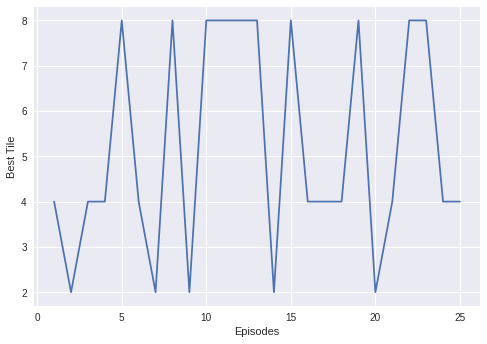

╒═════╤═════╤═════╤══════╤══════╤══════╤═══════╕
│   2 │   4 │   8 │   16 │   32 │   64 │   128 │
╞═════╪═════╪═════╪══════╪══════╪══════╪═══════╡
│   5 │  10 │  10 │    0 │    0 │    0 │     0 │
╘═════╧═════╧═════╧══════╧══════╧══════╧═══════╛
Tue Aug 10 21:29:25 2021


In [ ]:
do_hundrad_twenty_eight_evaluation(model,env)

print(ctime())